In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
import numpy as np
import torch.nn.functional as F

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Load the data: the Cats vs Dogs dataset

In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [3]:
!unzip -q kagglecatsanddogs_5340.zip

File successfully extracted.


### Filter out corrupted images

In [4]:
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1578 images.


### Calculating Mean and Std

In [8]:
transform= transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor()
])

In [9]:
dataset = datasets.ImageFolder(root='PetImages', transform=transform)


In [10]:
data_loader = DataLoader(dataset, batch_size=64, shuffle=False)

mean_sum = torch.zeros(3)
std_sum = torch.zeros(3)
total_batches = len(data_loader)

for images, _ in data_loader:
    mean_sum += torch.mean(images, dim=[0, 2, 3])
    std_sum += torch.std(images, dim=[0, 2, 3])

mean = mean_sum / total_batches
std = std_sum / total_batches

print("Mean of the dataset:", mean)
print("Standard deviation of the dataset:", std)

Mean of the dataset: tensor([0.4881, 0.4553, 0.4171])
Standard deviation of the dataset: tensor([0.2585, 0.2518, 0.2547])


### Generate a Dataset

In [5]:
dataset = datasets.ImageFolder(root='PetImages')

In [6]:
train_size = int(0.8 * len(dataset))
valid_size = train_size -16737
test_size = len(dataset) -  train_size -valid_size
train_dataset,valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size ,test_size])

In [7]:
print(f'train:{len(train_dataset)}')
print(f'test:{len(test_dataset)}')
print(f'valid:{len(valid_dataset)}')

train:18737
test:2685
valid:2000


In [8]:
train_transform= transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.RandomRotation(0.1),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4881, 0.4553, 0.4171),(0.2585, 0.2518, 0.2547))
])

test_transform = transforms.Compose([
    transforms.Resize((180, 180)),
    transforms.ToTensor(),
    transforms.Normalize((0.4881, 0.4553, 0.4171),(0.2585, 0.2518, 0.2547))
])

In [9]:
train_dataset.dataset.transform = train_transform
test_dataset.dataset.transform = test_transform
valid_dataset.dataset.transform= test_transform

In [10]:
train_loader = DataLoader(train_dataset, batch_size =32, shuffle=True)
test_loader = DataLoader (test_dataset, batch_size= 32, shuffle=False)
valid_loader = DataLoader(valid_dataset,batch_size=32, shuffle=False)

### Visualize the data

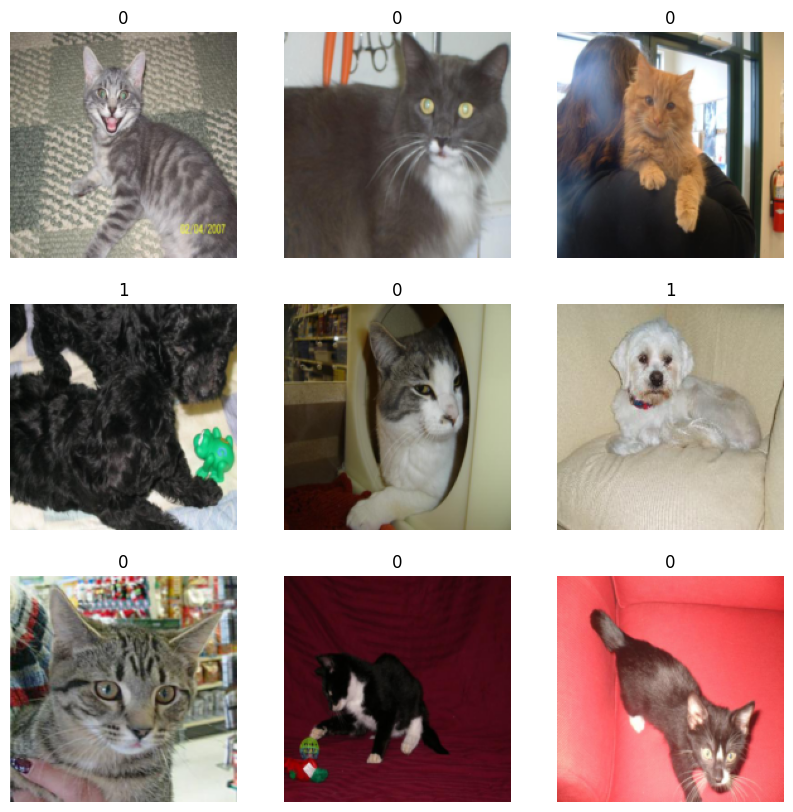

In [15]:
plt.figure(figsize=(10, 10))
for images, labels in train_loader:
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image_np = np.transpose(images[i].numpy(), (1, 2, 0))
        image_np = np.clip(image_np, 0, 1)
        plt.imshow(image_np)
        plt.title(int(labels[i]))
        plt.axis("off")
plt.show()

### Using image data augmentation

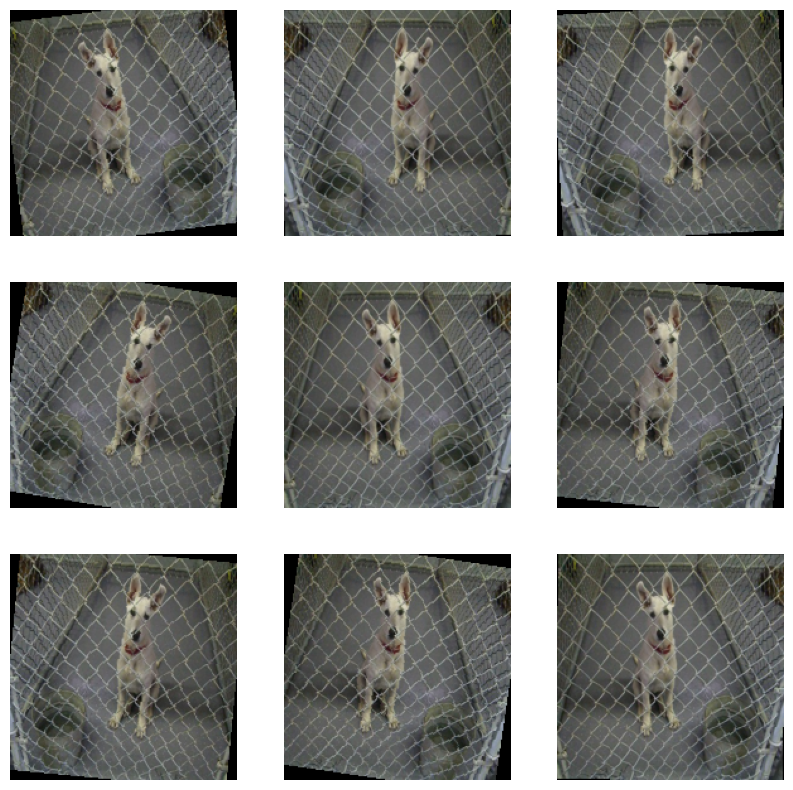

In [16]:
data_augmentation_transforms = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10)
])

def data_augmentation(images):
    augmented_images = []
    for img in images:
        augmented_img = data_augmentation_transforms(img)
        augmented_images.append(augmented_img)
    return torch.stack(augmented_images)


plt.figure(figsize=(10, 10))
for images, _ in train_loader:
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        image = np.clip(augmented_images[1], 0, 1)
        plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
        plt.axis("off")
    break
plt.show()

### Build a model

In [11]:

class SeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(SeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(Block, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.residual = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )
        self.relu= nn.ReLU()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.residual(x)
        out = self.relu(out)
        return out
    
class CAT_DOG_MODEL(nn.Module):
    def __init__(self, num_classes=2):
        super(CAT_DOG_MODEL, self).__init__()
        self.preprocess = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.blocks = nn.Sequential(
            Block(128, 256, stride=2),
            Block(256, 512, stride=2),
            Block(512, 728, stride=2)
        )
        
        self.sep_conv = SeparableConv2d(728, 1024, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(1024)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        if num_classes == 2:
            self.fc = nn.Linear(1024, 1)
        else:
            self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.preprocess(x)
        x = self.blocks(x)
        x = self.sep_conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [12]:
model = CAT_DOG_MODEL().to(device)
model

CAT_DOG_MODEL(
  (preprocess): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (blocks): Sequential(
    (0): Block(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (residual): Sequential(
        (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
    (1): Block(
      (conv1): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (

In [13]:
summary(model, (3, 180, 180))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 90, 90]         --
|    └─Conv2d: 2-1                       [-1, 128, 90, 90]         3,584
|    └─BatchNorm2d: 2-2                  [-1, 128, 90, 90]         256
|    └─ReLU: 2-3                         [-1, 128, 90, 90]         --
├─Sequential: 1-2                        [-1, 728, 12, 12]         --
|    └─Block: 2-4                        [-1, 256, 45, 45]         --
|    |    └─Conv2d: 3-1                  [-1, 256, 45, 45]         294,912
|    |    └─BatchNorm2d: 3-2             [-1, 256, 45, 45]         512
|    |    └─ReLU: 3-3                    [-1, 256, 45, 45]         --
|    |    └─Conv2d: 3-4                  [-1, 256, 45, 45]         589,824
|    |    └─BatchNorm2d: 3-5             [-1, 256, 45, 45]         512
|    |    └─Sequential: 3-6              [-1, 256, 45, 45]         33,280
|    |    └─ReLU: 3-7                    [-1, 256, 45, 45]       

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 128, 90, 90]         --
|    └─Conv2d: 2-1                       [-1, 128, 90, 90]         3,584
|    └─BatchNorm2d: 2-2                  [-1, 128, 90, 90]         256
|    └─ReLU: 2-3                         [-1, 128, 90, 90]         --
├─Sequential: 1-2                        [-1, 728, 12, 12]         --
|    └─Block: 2-4                        [-1, 256, 45, 45]         --
|    |    └─Conv2d: 3-1                  [-1, 256, 45, 45]         294,912
|    |    └─BatchNorm2d: 3-2             [-1, 256, 45, 45]         512
|    |    └─ReLU: 3-3                    [-1, 256, 45, 45]         --
|    |    └─Conv2d: 3-4                  [-1, 256, 45, 45]         589,824
|    |    └─BatchNorm2d: 3-5             [-1, 256, 45, 45]         512
|    |    └─Sequential: 3-6              [-1, 256, 45, 45]         33,280
|    |    └─ReLU: 3-7                    [-1, 256, 45, 45]       

### Train the model

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4,weight_decay=1e-4)

In [16]:
def train (model,loader,critation,optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        targets = targets.unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = critation(outputs.float(), targets.float())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predictions = torch.round(torch.sigmoid(outputs))
        total += targets.size(0)
        correct += predictions.eq(targets).sum().item()

    train_loss = running_loss / len(loader)
    train_accuracy = correct / total
    
    
    return train_loss, train_accuracy

In [17]:
def evaluation (model,loader,critation):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            targets= targets.unsqueeze(1)
            outputs = model(inputs)
            loss = critation(outputs.float(), targets.float())

            running_loss += loss.item()
            predictions = torch.round(torch.sigmoid(outputs))
            total += targets.size(0)
            correct += predictions.eq(targets).sum().item()

    valid_loss = running_loss / len(loader)
    valid_accuracy = correct / total

    return valid_loss, valid_accuracy

In [18]:
num_epochs = 15
epoch_counter = 0
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []
best_accuracy = 0.0
patience = 3
epoch_num_improve = 0



for epoch in tqdm(range(num_epochs)):
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_accuracy = evaluation(model, valid_loader, criterion)  

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_accuracies.append(valid_accuracy)
    # if epoch % 5 == 0:
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Test Loss: {valid_loss:.4f} | Test Accuracy: {valid_accuracy:.4f}")
    print()
    epoch_counter+=1
    
    
    #Early Stopping
    if valid_accuracy > best_accuracy:
      best_accuracy = valid_accuracy
      epoch_num_improve = 0
      torch.save(model.state_dict(), "best_model.pth")
    else:
      epoch_num_improve += 1
      if epoch_num_improve > patience:
        print(f"Early stopping, best accuracy {best_accuracy}")
        break

  7%|▋         | 1/15 [02:07<29:43, 127.36s/it]

Epoch 1/15:
Train Loss: 0.6268 | Train Accuracy: 0.6443
Test Loss: 0.5738 | Test Accuracy: 0.6870



 13%|█▎        | 2/15 [04:31<29:44, 137.27s/it]

Epoch 2/15:
Train Loss: 0.5406 | Train Accuracy: 0.7245
Test Loss: 0.5214 | Test Accuracy: 0.7325



 20%|██        | 3/15 [09:21<41:24, 207.01s/it]

Epoch 3/15:
Train Loss: 0.4579 | Train Accuracy: 0.7831
Test Loss: 0.4275 | Test Accuracy: 0.7880



 27%|██▋       | 4/15 [12:54<38:20, 209.15s/it]

Epoch 4/15:
Train Loss: 0.3978 | Train Accuracy: 0.8206
Test Loss: 0.4004 | Test Accuracy: 0.8255



 33%|███▎      | 5/15 [16:20<34:42, 208.28s/it]

Epoch 5/15:
Train Loss: 0.3463 | Train Accuracy: 0.8523
Test Loss: 0.3224 | Test Accuracy: 0.8580



 40%|████      | 6/15 [20:27<33:12, 221.35s/it]

Epoch 6/15:
Train Loss: 0.2797 | Train Accuracy: 0.8822
Test Loss: 0.2520 | Test Accuracy: 0.9015



 47%|████▋     | 7/15 [23:47<28:35, 214.45s/it]

Epoch 7/15:
Train Loss: 0.2321 | Train Accuracy: 0.9031
Test Loss: 0.2557 | Test Accuracy: 0.8895



 53%|█████▎    | 8/15 [27:48<25:59, 222.81s/it]

Epoch 8/15:
Train Loss: 0.1898 | Train Accuracy: 0.9222
Test Loss: 0.2281 | Test Accuracy: 0.9105



 60%|██████    | 9/15 [31:42<22:38, 226.47s/it]

Epoch 9/15:
Train Loss: 0.1595 | Train Accuracy: 0.9360
Test Loss: 0.2383 | Test Accuracy: 0.9060



 67%|██████▋   | 10/15 [36:31<20:28, 245.77s/it]

Epoch 10/15:
Train Loss: 0.1395 | Train Accuracy: 0.9441
Test Loss: 0.2267 | Test Accuracy: 0.9060



 73%|███████▎  | 11/15 [39:54<15:29, 232.41s/it]

Epoch 11/15:
Train Loss: 0.1093 | Train Accuracy: 0.9593
Test Loss: 0.2041 | Test Accuracy: 0.9240



 80%|████████  | 12/15 [44:43<12:29, 249.78s/it]

Epoch 12/15:
Train Loss: 0.0987 | Train Accuracy: 0.9619
Test Loss: 0.1680 | Test Accuracy: 0.9400



 87%|████████▋ | 13/15 [48:09<07:53, 236.53s/it]

Epoch 13/15:
Train Loss: 0.0831 | Train Accuracy: 0.9690
Test Loss: 0.2128 | Test Accuracy: 0.9185



 93%|█████████▎| 14/15 [52:19<04:00, 240.58s/it]

Epoch 14/15:
Train Loss: 0.0674 | Train Accuracy: 0.9749
Test Loss: 0.2344 | Test Accuracy: 0.9080



100%|██████████| 15/15 [58:26<00:00, 233.79s/it]

Epoch 15/15:
Train Loss: 0.0648 | Train Accuracy: 0.9764
Test Loss: 0.2696 | Test Accuracy: 0.9075



### Learning Curves

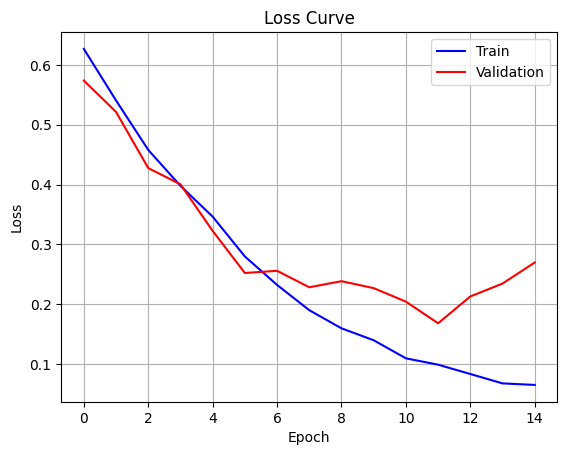

In [27]:
plt.plot(range(num_epochs), train_losses, 'b-', label='Train')
plt.plot(range(num_epochs), valid_losses, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.legend()

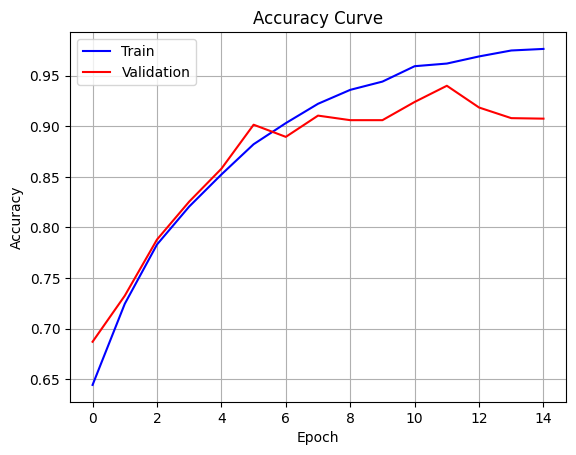

In [28]:
plt.plot(range(num_epochs), train_accuracies, 'b-', label='Train')
plt.plot(range(num_epochs), valid_accuracies, 'r-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.grid(True)
plt.legend()

This image is 86.37% cat and 13.63% dog.


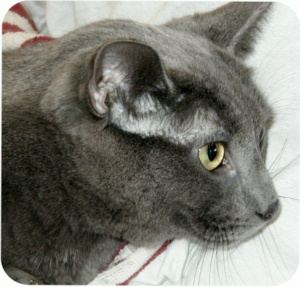

In [23]:
from PIL import Image

img_path = "C:\\Users\\ASUS\\OneDrive\\Desktop\\6\\PetImages\\Cat\\6779.jpg"

img = Image.open(img_path)

transform = transforms.Compose([
    transforms.Resize((180,180)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0)  

model.eval()  
with torch.no_grad():
    outputs = model(img_tensor.to(device))
score = torch.sigmoid(outputs).item()
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")
img


In [30]:
_, test_accuracy = evaluation(model, test_loader, criterion)
print(f'Test Accuracy={test_accuracy:.4}%')

Test Accuracy=0.9035%
